## This is the last practical task of Sirius summer school "Applying AI for Med image analysis". 
Practical tasks take form of jupyter notebook with example code in the begging and some tasks in the end. Please, provide your solution in form of python code. Read hints, google a lot, don't hesitate to ask us directyl and most importatly - 
<span style="color:blue">have fun</span>.

**Topic**: Shape models 

**To submit**: New version of the notebook, with your code. 

#### Important module imports

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial import procrustes
import sklearn
from sklearn import decomposition
import glob
import os
from PIL import Image
import numpy as np
import re
%matplotlib inline 


#### Data is stored in .pfs files, which contain points. Let's load them and plot ontop of image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


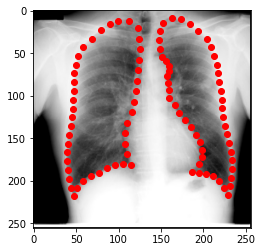

In [ ]:

def parseFile(fileName):
    """
    Dark magic function to load points into dict
    """
    objects = {}
    pattern = re.compile("[-+]?\d*\.\d+|\d+")
    points = []
    currentName = ''
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        if '  [Label=' in line:
            if currentName != '':
                objects[currentName] = points
            points = []
            currentName = line[9:-2]
        if line[0:4] == '  { ':
            splitted = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            points.append([float(splitted[0]), float(splitted[1])])
    objects[currentName] = points
    return objects
        
def readBothLungFields(fileName, scaler = 4):
    objects = parseFile(fileName)
    lungs = np.concatenate((np.asarray(objects['right lung']),
                            np.asarray(objects['left lung']))) / scaler
    return lungs

def readCompleteDatabase(dataFolder):
    database = {}
    files = os.listdir(dataFolder + '/Images/' )
    for file in files:
        caseName = os.path.split(file)[-1][:-4]
        im = Image.open(dataFolder + '/Images/' + caseName + '.bmp')
        pIm = np.array(im)[:, :, 0]
        databaseElement = {}
        databaseElement['points'] = readBothLungFields(dataFolder+"/scratch/landmarks/"+caseName+".pfs")
        databaseElement['image'] = im
        database[caseName] = databaseElement
    return database

database = readCompleteDatabase("/content/drive/My Drive/Sirius 2020/data/Lung images from Bram/")
plt.scatter(database['JPCLN001']['points'][:, 0], database['JPCLN001']['points'][:, 1], c = 'r')
plt.imshow(database['JPCLN001']['image'], cmap='gray')

## **Task 1 Procrustes:**
- Normalize the scale, translation and rotation for the shape model before segmentation with active shape models. Do not forget to save scale factors in the database.
- Given: Database of lung shapes
- Do: fill in applyProcrustes function, which would normalize all shapes in database. . 


Hint https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy

**Use the code from Hint link and apply Procrustes to all images with reference image JPCN001**

**And change the points to new created points in new database, also return transformations as array of scale, rotation, translation values**

In [ ]:
def procrustes1(X, Y, scaling=True, reflection='best'):
    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY
    #Scaling
    ssX = (X0**2.).sum() 
    ssY = (Y0**2.).sum() 

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

In [ ]:
# def applyProcrustes(database):
#     X = database['JPCLN001']['points']
#     transforms = {}
#     # database1 = database
#     for image, points in database.items():
#         Y = points['points']
#         d, Z, transform = procrustes1(X, Y)
#         transforms[image] = transform
#         database[image]['points'] = Z
#     return transforms, database

# def applyProcrustes1(database):
#     X = database['JPCLN001']['points']
#     transforms = {}
#     # database1 = database
#     for image, points in database.items():
#         Y = points['points']
#         d, Z, transform = procrustes1(X, Y)
#         transforms[image] = transform
#         database[image]['points'] = Z
#     return

In [ ]:
def applyProcrustes2(database):
    total = []
    keys = list(database.keys())
    for i in range(0, len(keys)):
        total.append(database[keys[i]]['points'])
    mean_Matrix = np.sum(total, axis=0) / len(keys) #mean matrix values over all images

    transforms = {}
    # database1 = database
    for image, points in database.items():
        Y = points['points']
        d, Z, transform = procrustes1(mean_Matrix, Y)
        transforms[image] = transform
        database[image]['points'] = Z
    return

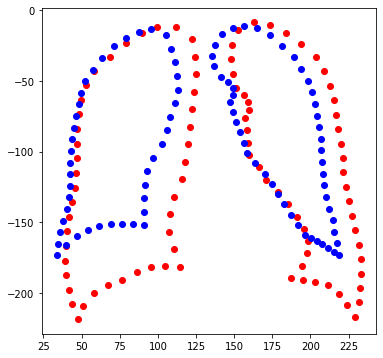

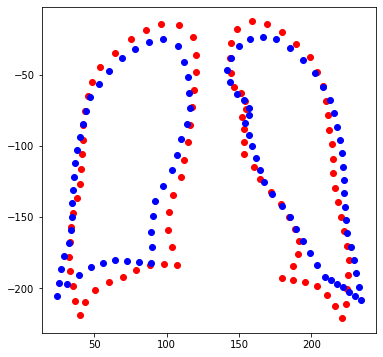

In [ ]:
# transforms, database1 = applyProcrustes(database)
# database = readCompleteDatabase("/content/drive/My Drive/Sirius 2020/data/Lung images from Bram/")
plt.figure(1, figsize=(6, 6))
plt.scatter(database['JPCLN001']['points'][:, 0], -database['JPCLN001']['points'][:, 1], c = 'r')
plt.scatter(database['JPCLN003']['points'][:, 0], -database['JPCLN003']['points'][:, 1], c = 'b')

applyProcrustes2(database)

plt.figure(2, figsize=(6, 6))
plt.scatter(database['JPCLN001']['points'][:, 0], -database['JPCLN001']['points'][:, 1], c = 'r')
plt.scatter(database['JPCLN003']['points'][:, 0], -database['JPCLN003']['points'][:, 1], c = 'b')

# Principal component analysis

## **Task 2 PCA:**
- Compute PCA for lung shape and generate different lung field variaitons
- Given: Database of lung shapes and applyProcrustes function from previous step
- Do: fill in generatePCA function, which would generate pca decomposition of lung shapes. Visualize some of them, using provided function


Hint https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

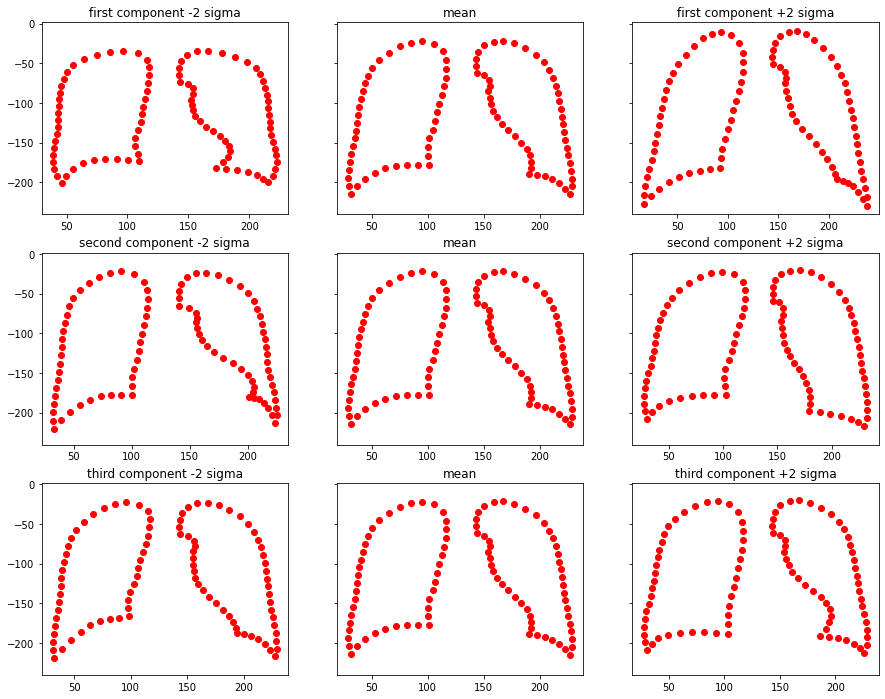

In [ ]:
from sklearn.decomposition import PCA

# def generatePCA(database):
#     for image, array in database.items():
#         points = array['points']
#         pca = PCA(n_components=2)
#         pca.fit(points)
#     # raise NotImplementedError("please fill in this function")
#     return pca
def generatePCA(database):
    keys = list(database.keys())
    dataArray = np.zeros((len(keys), 2 * database[keys[0]]['points'].shape[0]))
    for i in range(0, len(keys)):
        dataArray[i, :] = database[keys[i]]['points'].flatten('F')
    pca = PCA(n_components=dataArray.shape[1])
    pca.fit(dataArray)
    return pca


def visualizePCAComponents(database, pca):
    keys = list(database.keys())
    dataArray = np.zeros((len(keys), 2 * database[keys[0]]['points'].shape[0]))
    for i in range(0, len(keys)):
        dataArray[i, :] = database[keys[i]]['points'].flatten('F')
    
    meanShape = np.mean(dataArray, axis = 0)
    size = [[0, int(meanShape.shape[0] / 2)], [int(meanShape.shape[0] / 2), meanShape.shape[0]]]
    # plt.figure(1)
    # print('variance = ', pca.explained_variance_)
    # print('explained_variance_ratio_ = ', pca.explained_variance_ratio_)
    # print('singular_values_ = ', pca.singular_values_)
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharey=True)
    
    axs[0][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[1][0]:size[1][1]], c = 'r')
    axs[0][0].title.set_text('first component -2 sigma')
    axs[0][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[0][1].title.set_text('mean')
    axs[0][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[1][0]:size[1][1]], c = 'r')
    axs[0][2].title.set_text('first component +2 sigma')
    
    
    axs[1][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[1][0]:size[1][1]], c = 'r')
    axs[1][0].title.set_text('second component -2 sigma')
    axs[1][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[1][1].title.set_text('mean')
    axs[1][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[1][0]:size[1][1]], c = 'r')
    axs[1][2].title.set_text('second component +2 sigma')
    
    axs[2][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[1][0]:size[1][1]], c = 'r')
    axs[2][0].title.set_text('third component -2 sigma')
    axs[2][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[2][1].title.set_text('mean')
    axs[2][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[1][0]:size[1][1]], c = 'r')
    axs[2][2].title.set_text('third component +2 sigma')
    
    return

applyProcrustes(database)
pca = generatePCA(database)
visualizePCAComponents(database, pca)
    
